In [15]:
import torch
from torch import nn
import numpy as np

In [12]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner

In [3]:
partitioner = DirichletPartitioner(
            num_partitions=4,
            partition_by="label",
            alpha=0.01,
            min_partition_size=0,
            self_balancing=False
        )

In [4]:
fds = FederatedDataset(
                dataset="mnist",
                partitioners={"train": partitioner},
            )

In [5]:
train_partitions = [fds.load_partition(i, split="train") for i in range(4)] 

In [6]:
from collections import Counter

In [7]:
# Obter a coluna de rótulos
labels = [train_partition['label'] for train_partition in train_partitions]

# Contar a frequência de cada classe
class_distributions = [Counter(label) for label in labels]

# Exibir a distribuição das classes
print(class_distributions)

[Counter({7: 6264, 9: 5948, 6: 5676, 5: 4669, 1: 178}), Counter({1: 6563, 5: 707, 4: 4, 7: 1, 9: 1}), Counter({2: 5958, 8: 5850, 4: 5838, 6: 241}), Counter({3: 6131, 0: 5923, 5: 45, 8: 1, 1: 1, 6: 1})]


In [17]:
import pandas as pd

# Criar um DataFrame com a distribuição de classes por partição
df_class_distribution = pd.DataFrame(class_distributions).fillna(0).astype(int)
df_class_distribution.index.name = 'Partição'
df_class_distribution.columns.name = 'Classe'

# Ordenar as colunas em ordem crescente de rótulo
df_class_distribution = df_class_distribution[sorted(df_class_distribution.columns)]

# Exibir a tabela
print(df_class_distribution)

Classe       0     1     2     3     4     5     6     7     8     9
Partição                                                            
0            0   178     0     0     0  4669  5676  6264     0  5948
1            0  6563     0     0     4   707     0     1     0     1
2            0     0  5958     0  5838     0   241     0  5850     0
3         5923     1     0  6131     0    45     1     0     1     0


In [8]:
total_class_counts = Counter()
for distribution in class_distributions:
    total_class_counts.update(distribution)

print(total_class_counts)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [9]:
partitioner2 = DirichletPartitioner(
            num_partitions=1,
            partition_by="label",
            alpha=0.01,
            min_partition_size=0,
            self_balancing=False)

fds2 = FederatedDataset(
                dataset="mnist",
                partitioners={"train": partitioner2},
            )

In [10]:
train_partition2 = fds2.load_partition(0, split="train")

In [11]:
labels2 = train_partition2["label"]
class_distribution2 = Counter(labels2)
print(class_distribution2)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [21]:
test = fds3.load_split("test")
labels_test = test["label"]
test_ditribution = Counter(labels_test)
print(test_ditribution)

Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [14]:
partitioner3 = IidPartitioner(num_partitions=4)
fds3 = FederatedDataset(dataset="mnist", partitioners={"train": partitioner3})
partitions3 = [fds3.load_partition(i) for i in range(4)]
labels3 = [partition["label"] for partition in partitions3]
class_distributions3 = [Counter(label) for label in labels3]
print(class_distributions3)

[Counter({1: 1709, 3: 1601, 7: 1532, 0: 1504, 2: 1490, 6: 1476, 9: 1459, 4: 1447, 8: 1436, 5: 1346}), Counter({1: 1678, 8: 1514, 7: 1508, 3: 1506, 4: 1500, 9: 1497, 6: 1476, 2: 1471, 0: 1468, 5: 1382}), Counter({7: 1661, 1: 1634, 3: 1502, 4: 1494, 2: 1486, 9: 1486, 6: 1484, 8: 1477, 0: 1429, 5: 1347}), Counter({1: 1721, 7: 1564, 3: 1522, 0: 1522, 2: 1511, 9: 1507, 6: 1482, 8: 1424, 4: 1401, 5: 1346})]


In [15]:
total_class_counts3 = Counter()
for distribution in class_distributions3:
    total_class_counts3.update(distribution)

print(total_class_counts3)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [3]:
from PIL import Image
from IPython.display import Image as IPImage, display

In [ ]:
def create_gif(image_files, output_path, duration=200):
    """
    Cria um GIF animado a partir de uma sequência de imagens.

    Args:
        image_files (list): Lista de caminhos das imagens.
        output_path (str): Caminho para salvar o GIF.
        duration (int): Tempo de exibição de cada frame (em ms).

    Returns:
        None
    """
    frames = [Image.open(img) for img in image_files]  # Carregar imagens
    frames[0].save(output_path, format="GIF", save_all=True, append_images=frames[1:], duration=duration, loop=0)
    display(IPImage(filename=output_path))


In [11]:
import os

In [12]:
os.getcwd()

'/Users/Mara/Documents/Mestrado/Pesquisa/GeraFed/GeraFed'

#### Evolução modelo global

In [ ]:
# Exemplo de uso
image_files = ["../imagens geradas/mnist_CGAN_r0_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r1_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r2_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r3_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r4_100e_64_100z_10c_0.0001lr_niid_01dir.png"]
create_gif(image_files, "global.gif", duration=1000)

In [ ]:
def resize_and_pad(image, target_size, background_color=(255, 255, 255)):
    """
    Redimensiona a imagem para caber dentro de target_size mantendo a proporção,
    e adiciona padding para atingir exatamente target_size.
    
    Parâmetros:
      image          : objeto PIL.Image a ser redimensionado.
      target_size    : tupla (largura, altura) desejada.
      background_color: cor de fundo para o padding.
    
    Retorna:
      Imagem redimensionada com padding.
    """
    img = image.copy()
    # Redimensiona mantendo a proporção para caber dentro do target_size
    img.thumbnail(target_size, Image.Resampling.LANCZOS)
    # Cria uma nova imagem com o tamanho alvo e cor de fundo
    new_img = Image.new("RGB", target_size, background_color)
    # Calcula a posição para centralizar a imagem redimensionada
    x = (target_size[0] - img.width) // 2
    y = (target_size[1] - img.height) // 2
    new_img.paste(img, (x, y))
    return new_img

def create_federated_collage(
    agg_image_paths,       # Lista de caminhos para as imagens grandes (1 por round)
    clients_image_paths,   # Lista de listas: para cada round, lista de caminhos de imagens de clientes
    big_scale=2,           # Fator de escala da imagem grande em relação à imagem pequena
    small_size=(64, 64),   # Tamanho desejado para cada imagem pequena (largura, altura)
    background_color=(255, 255, 255),
    save_path="collage.png"
):
    """
    Cria um mosaico onde cada round tem:
      - 1 imagem "agregada" (maior) à esquerda
      - Imagens de cliente empilhadas verticalmente à direita

    Cada imagem é redimensionada mantendo a proporção original e centralizada
    em uma caixa do tamanho desejado.

    Parâmetros:
      agg_image_paths      : lista de strings (caminhos) para as imagens agregadas (1 por round)
      clients_image_paths  : lista de listas de strings. Cada sublista é a lista de caminhos das imagens dos clientes daquele round
      big_scale            : fator de escala da imagem grande em relação às pequenas
      small_size           : (largura, altura) desejado para cada imagem pequena
      background_color     : cor de fundo do mosaico (RGB)
      save_path            : caminho do arquivo final a ser salvo

    Retorna:
      Um objeto PIL.Image com o mosaico criado.
    """
    # Verifica se temos a mesma quantidade de rounds
    assert len(agg_image_paths) == len(clients_image_paths), \
        "Número de imagens agregadas deve bater com número de listas de clientes."

    # Carrega todas as imagens agregadas (rounds)
    agg_images = [Image.open(path).convert("RGB") for path in agg_image_paths]

    # Carrega todas as imagens de clientes (lista de listas)
    client_images = []
    for round_paths in clients_image_paths:
        imgs = [Image.open(p).convert("RGB") for p in round_paths]
        client_images.append(imgs)

    # Define tamanhos: cada imagem pequena terá small_size
    # A imagem agregada ocupará uma caixa de tamanho (big_scale * small_size)
    small_w, small_h = small_size
    big_w, big_h = big_scale * small_w, big_scale * small_h

    # Redimensiona as imagens mantendo a proporção (com padding)
    for i, img in enumerate(agg_images):
        agg_images[i] = resize_and_pad(img, (big_w, big_h), background_color)

    for i, imgs in enumerate(client_images):
        resized_list = []
        for im in imgs:
            resized_list.append(resize_and_pad(im, (small_w, small_h), background_color))
        client_images[i] = resized_list

    # Número de rounds
    num_rounds = len(agg_images)

    # Determina o número máximo de clientes em qualquer round para definir a altura do bloco
    max_clients = max(len(imgs) for imgs in client_images)
    block_h = max(big_h + small_h, max_clients * small_h)
    block_w = big_w + small_w - 80# Largura do bloco do round

    total_w = num_rounds * block_w
    total_h = block_h

    # Cria a imagem final (mosaico) com o fundo especificado
    collage = Image.new("RGB", (total_w, total_h), color=background_color)

    # Para cada round, posiciona a imagem agregada e as imagens de cliente
    for r in range(num_rounds):
        x_offset = r * block_w
        # Coloca a imagem agregada (round) à esquerda do bloco
        collage.paste(agg_images[r], (x_offset, small_h))
    
    for r in range(num_rounds): 
        x_offset = r * block_w   # Empilha as imagens dos clientes verticalmente à direita
        y_offset = 0
        for c_img in client_images[r]:
            collage.paste(c_img, (x_offset + big_w-60, y_offset))
            y_offset += small_h

    # Salva a imagem final
    collage.save(save_path)
    print(f"Mosaico criado e salvo em: {save_path}")

    return collage

In [5]:
agg_image_paths = [f"FULL/mnist_CGAN_r{i}_100e_64b_100z_10c_0.0001lr_niid_01dir.png" for i in range(5)]

In [6]:
client_image_paths = [[f"FULL/mnist_CGAN_r{i}_100e_64b_100z_10c_0.0001lr_niid_01dir_cliente{j}.png" for j in range(4)] for i in range(1, 6)]

Mosaico criado e salvo em: FULL_4c_100e_fedavg_niid01.png


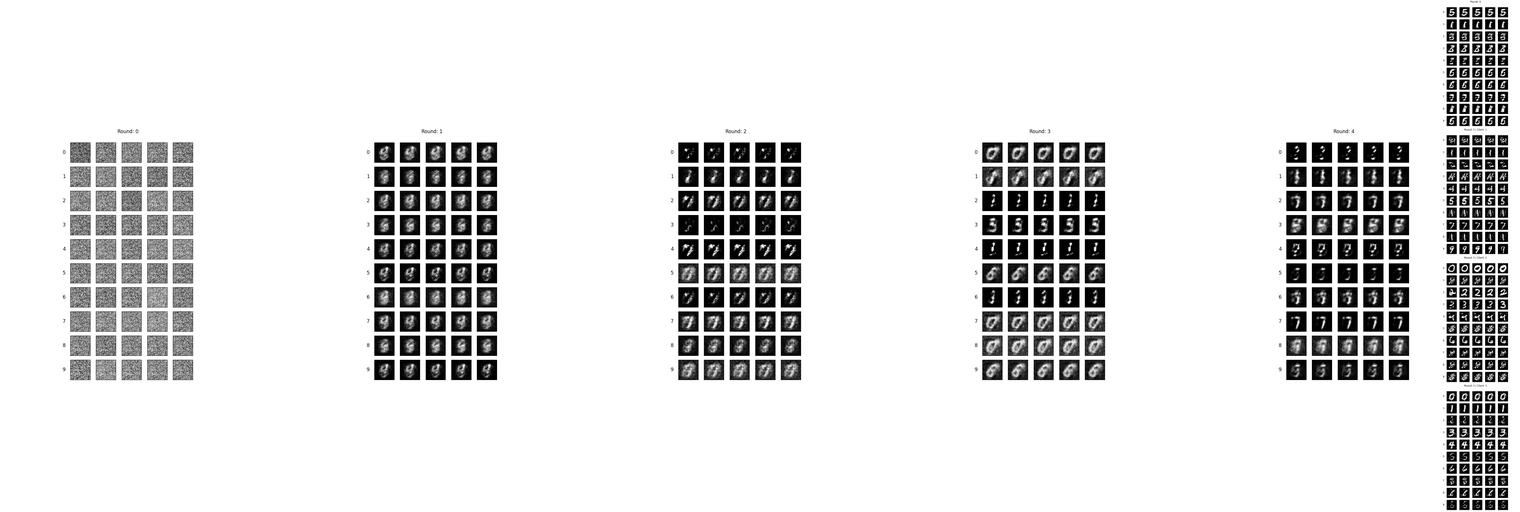

In [49]:
create_federated_collage(
    agg_image_paths=agg_image_paths,
    clients_image_paths=client_image_paths,
    big_scale=2,
    small_size=(128, 128),
    background_color=(255, 255, 255),
    save_path="FULL_4c_100e_fedavg_niid01.png"
)